In [ ]:
import gftt
import numpy as np
import matplotlib.pyplot as plt

#### 3.1 image with many off-ice pixels

In [13]:
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'
# CARST files (Vx and Vy)
carst_geotiff_x = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vx.tif'
carst_geotiff_y = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vy.tif'

**old code (using all 721549 samples)**

This would take 2 hours to run. Not very effective because for many areas the KDE is just very low.

In [14]:
# %%time
# vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp)
# max_n = 721549

In [15]:
#### These numbers are very similar from only using n=10000 points.
# print(np.sum(thres_idx) / vx.shape)
# print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
# print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

**New code (using 10000 samples)**

CPU times: user 1.53 s, sys: 83.4 ms, total: 1.62 s
Wall time: 1.95 s


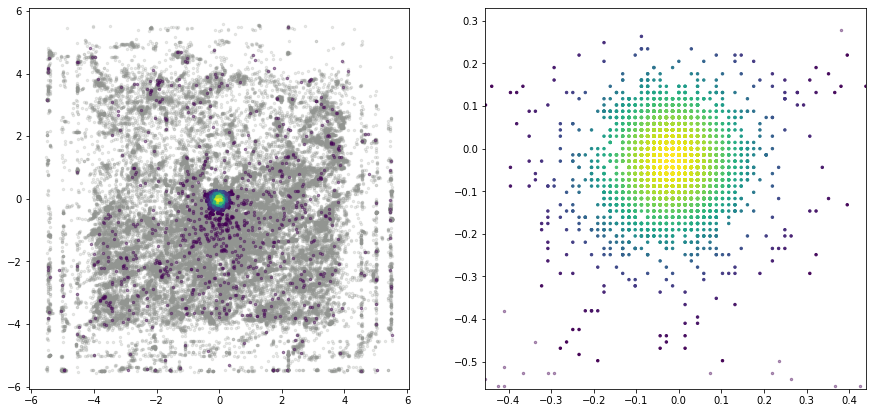

In [16]:
%%time
fig, ax2 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax2:
    ax.axis('equal')
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp, max_n=10000, ax=ax2[0])
gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax2[1])

In [17]:
print(np.sum(thres_idx) / vx.shape)
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

[0.9116]
Vx std: 0.689474  m/day
Vy std: 0.695841  m/day


In [18]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.062789  m/day
Vy std: 0.069133  m/day


### Test with and without weights

In [34]:
demo = df.loc[72]
demo

Date                                           LS8-20180304-20180405
Chip (px)                                                      multi
Resolution (px)                                                   16
Prefilter                                                       NAOF
Subpixel                                       interest point groups
Software                                                         GIV
Vx                 /home/jovyan/Projects/PX_comparison/PX/GIV/u_l...
Vy                 /home/jovyan/Projects/PX_comparison/PX/GIV/v_l...
Name: 72, dtype: object

In [35]:
def off_ice_errors_withweight(vfile=None, vxfile=None, vyfile=None, wfile=None, off_ice_area=None, thres_sigma=3.0, plot=True, ax=None, max_n=10000):
    """
    vfile: str, geotiff file path
    vxfile: str, geotiff file path
    vyfile: str, geotiff file path
    off_ice_area: str, off ice area (shapefile) file path
    max_n: maximum samples to calculate Gaussian KDE
    ----
    returns:
    vx: 1-d np array, vx values from all pixels within the off-ice area.
    vy: 1-d np array, vy values from all pixels within the off-ice area.
    z: 1-d np array (float), Gaussian KDE values for all pixels within the off-ice area.
    thres_idx: 1-d np array (boolean), indices of pixels with a z value within a pre-defined confidence level. 
               when thres_sigma=3.0, confidence level = 99.7%.
    ==== or ====
    v: 1-d np array, v values from all pixels within the off-ice area.
    bins: plt.hist return with 100 bins and v^2 as input
    ----
    according to
    https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal
    """  
    from shapely.geometry import mapping
    from rasterio.mask import mask
    from scipy.stats import gaussian_kde
    shapefile = gpd.read_file(off_ice_area)
    geoms = shapefile.geometry.values
    geoms = [mapping(geoms[i]) for i in range(len(geoms))]
    
    def clip(gtiff, geoms):
        with rasterio.open(gtiff) as src:
            out_image, out_transform = mask(src, geoms, crop=True, nodata=-9999.0)
        try:
            clipped_data = out_image.data[0]
        except NotImplementedError:
            clipped_data = out_image[0]
        return clipped_data
    
    vx_full = None
    vy_full = None
    w_full = None

    if vxfile is not None and vyfile is not None:
        case = 1
        vx = clip(vxfile, geoms)
        vy = clip(vyfile, geoms)
        nonNaN_pts_idx = np.logical_and(vx > -9998, vy > -9998)
        vx = vx[nonNaN_pts_idx]  # remove NaN points
        vy = vy[nonNaN_pts_idx]  # remove NaN points
        if wfile is not None:
            w_full = clip(wfile, geoms)
            w_full = w_full[nonNaN_pts_idx]  # remove NaN points
    elif vfile is not None:
        case = 2
        v = clip(vfile, geoms)
        v = v[v > -9998]  # remove NaN points
    else:
        case = 0
        raise TypeError('Either vfile or vxfile+vyfile are required.')
        
    if case == 1:
        if wfile is not None:
            w = w_full
            xy = np.vstack([vx, vy, w])
        else:
            xy = np.vstack([vx, vy])
        
        if len(vx) > max_n:
            vx_full = vx[:]
            vy_full = vy[:]
            if wfile is not None:
                rng = np.random.default_rng()
                xy = rng.choice(xy, size=max_n, replace=False, axis=1)
                vx = xy[0, :]
                vy = xy[1, :]
                w = xy[2, :]
            else:
                ## See https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html#numpy.random.Generator.choice
                rng = np.random.default_rng()
                xy = rng.choice(xy, size=max_n, replace=False, axis=1)
                vx = xy[0, :]
                vy = xy[1, :]
                
        if wfile is not None:
            kernel = gaussian_kde(xy[:2, :], weights=xy[2, :])
            z = kernel(xy[:2, :])
        else:
            kernel = gaussian_kde(xy)
            z = kernel(xy)

        thres_multiplier = np.e ** (thres_sigma ** 2 / 2)   # normal dist., +- sigma number 
        thres = max(z) / thres_multiplier
        thres_idx = z >= thres
        idx = thres_idx    # alias

        if plot:
            if ax is None:
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                
            viridis = cm.get_cmap('viridis', 12)
            pt_style = {'s': 6, 'edgecolor': None}
            
            if vx_full is not None:
                ax.scatter(vx_full, vy_full, color='xkcd:gray', alpha=0.2, **pt_style)
            
            ax.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
            ax.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
            
        return vx, vy, z, thres_idx
    
    elif case == 2:
        
        if plot:
            if ax is None:
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                
        bins = ax.hist(v ** 2, 100);
        return v, bins

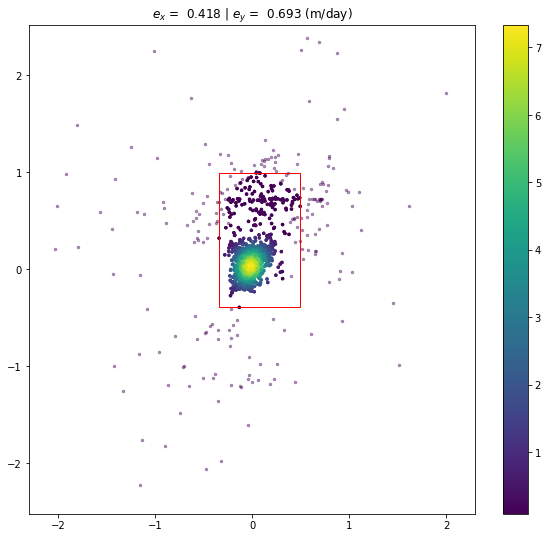

In [36]:
import matplotlib.patches as patches

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(10, 9))
vx, vy, z, thres_idx = off_ice_errors_withweight(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

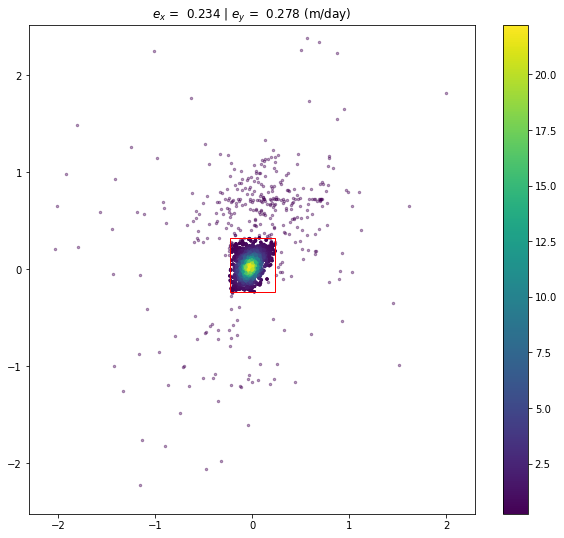

In [37]:
import matplotlib.patches as patches

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(10, 9))
vx, vy, z, thres_idx = off_ice_errors_withweight(vxfile=demo.Vx, vyfile=demo.Vy, wfile=demo.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

In [38]:
demo.Vx

'/home/jovyan/Projects/PX_comparison/PX/GIV/u_l12_NAOF_200.tif'